In [147]:
import numpy as np
import matplotlib.pyplot as plt

In [153]:
# Create triplet dataset

import os
import random
import numpy as np
from itertools import combinations

classes = np.zeros(1)

part = 3

classes_pre_triplet = np.zeros(1)
pretrain_dataset = np.zeros((1, 64, 64))
for n in range(28):
    if n==part:
        continue
    else:
        if n<=9:
            pretrain_data = np.load('../../data/interim/AVP/Dataset_Train_0' + str(n) + '_1024.npy')
            classes_str = np.load('../../data/interim/AVP/Classes_Train_0' + str(n) + '.npy')
            classes_pre = np.zeros(len(classes_str))
            for nc in range(len(classes_str)):
                if classes_str[nc]=='kd':
                    classes_pre[nc] = (n*4)
                elif classes_str[nc]=='sd':
                    classes_pre[nc] = (n*4)+1
                elif classes_str[nc]=='hhc':
                    classes_pre[nc] = (n*4)+2
                elif classes_str[nc]=='hho':
                    classes_pre[nc] = (n*4)+3
            classes_pre_triplet = np.concatenate((classes_pre_triplet, classes_pre))
            pretrain_dataset = np.vstack((pretrain_dataset, pretrain_data))
        else:
            pretrain_data = np.load('../../data/interim/AVP/Dataset_Train_' + str(n) + '_1024.npy')
            classes_str = np.load('../../data/interim/AVP/Classes_Train_' + str(n) + '.npy')
            classes_pre = np.zeros(len(classes_str))
            for nc in range(len(classes_str)):
                if classes_str[nc]=='kd':
                    classes_pre[nc] = (n*4)
                elif classes_str[nc]=='sd':
                    classes_pre[nc] = (n*4)+1
                elif classes_str[nc]=='hhc':
                    classes_pre[nc] = (n*4)+2
                elif classes_str[nc]=='hho':
                    classes_pre[nc] = (n*4)+3
            classes_pre_triplet = np.concatenate((classes_pre_triplet, classes_pre))
            pretrain_dataset = np.vstack((pretrain_dataset, pretrain_data))
classes_pre_triplet = classes_pre_triplet[1:]
pretrain_dataset = pretrain_dataset[1:]

num_classes = int(np.max(classes_pre_triplet)+1)

classes_pre_triplet_onset = np.zeros(1)
for n in range(28):
    if n==part:
        continue
    else:
        if n<=9:
            classes_pre_triplet_onset = np.concatenate((classes_pre_triplet_onset, np.load('../../data/interim/AVP/Syll_Onset_Train_0' + str(n) + '.npy')))
        else:
            classes_pre_triplet_onset = np.concatenate((classes_pre_triplet_onset, np.load('../../data/interim/AVP/Syll_Onset_Train_' + str(n) + '.npy')))
classes_pre_triplet_onset = classes_pre_triplet_onset[1:]

classes_pre_triplet_nucleus = np.zeros(1)
for n in range(28):
    if n==part:
        continue
    else:
        if n<=9:
            classes_pre_triplet_nucleus = np.concatenate((classes_pre_triplet_nucleus, np.load('../../data/interim/AVP/Syll_Nucleus_Train_0' + str(n) + '.npy')))
        else:
            classes_pre_triplet_nucleus = np.concatenate((classes_pre_triplet_nucleus, np.load('../../data/interim/AVP/Syll_Nucleus_Train_' + str(n) + '.npy')))
classes_pre_triplet_nucleus = classes_pre_triplet_nucleus[1:]

cmb = []
classes_syllables = np.zeros(len(classes_pre_triplet_onset))
for n in range(len(classes_pre_triplet_onset)):
    combination = [classes_pre_triplet_onset[n],classes_pre_triplet_nucleus[n]]
    if combination not in cmb:
        cmb.append(combination)
        classes_syllables[n] = cmb.index(combination)
    else:
        classes_syllables[n] = cmb.index(combination)

class_start_part = int(part*4)
class_end_part = class_start_part + 4

'''counter = 0
for n in range(num_classes):
    class_start = n//4
    class_end = class_start + 4
    if class_start==class_start_part:
        continue
    else:
        indices_sound = np.argwhere(classes_pre_triplet==n)[:,0]
        anchors_positives = list(combinations(indices_sound.tolist(),2))
        counter += len(anchors_positives)'''

counter = 0
for n in range(num_classes):
    class_start = n//4
    class_end = class_start + 4
    if class_start==class_start_part:
        continue
    else:
        for it in range(2):
            indices_sound = np.argwhere(classes_pre_triplet==n)[:,0]
            syllables_sound = classes_syllables[indices_sound.tolist()]
            unique_syllables = np.unique(syllables_sound)
            for sy in range(len(unique_syllables)):
                indices_sound_syll = indices_sound[np.argwhere(syllables_sound==unique_syllables[sy])[:,0].tolist()]
                anchors_positives = list(combinations(indices_sound_syll.tolist(),2))
                counter += len(anchors_positives)

triplet_dataset = np.zeros((counter,64,192))
c = 0

for n in range(num_classes):
    class_start = n//4
    class_end = class_start + 4
    if class_start==class_start_part:
        continue
    else:
        for it in range(2):
            indices_sound = np.argwhere(classes_pre_triplet==n)[:,0]
            syllables_sound = classes_syllables[indices_sound.tolist()]
            unique_syllables = np.unique(syllables_sound)
            indices_sounds_part = list(set(np.argwhere(classes_pre_triplet>=class_start)[:,0])&set(np.argwhere(classes_pre_triplet<class_end)[:,0]))
            indices_sounds_other = np.concatenate((np.argwhere(classes_pre_triplet<class_start)[:,0],np.argwhere(classes_pre_triplet>=class_end)[:,0]))
            for sy in range(len(unique_syllables)):
                indices_sound_syll = indices_sound[np.argwhere(syllables_sound==unique_syllables[sy])[:,0].tolist()]
                anchors_positives = list(combinations(indices_sound_syll.tolist(),2))
                L = len(anchors_positives)
                L_half = L//2
                negatives_part = np.random.choice(indices_sounds_part, size=L_half, replace=True)
                negatives_other = np.random.choice(indices_sounds_other, size=L-L_half, replace=True)
                for s in range(L_half):
                    triplet_dataset[c,:,:64] = pretrain_dataset[anchors_positives[s][0]]
                    triplet_dataset[c,:,64:128] = pretrain_dataset[anchors_positives[s][1]]
                    triplet_dataset[c,:,128:192] = pretrain_dataset[negatives_part[s]]
                    c += 1
                for s in range(L_half,L):
                    triplet_dataset[c,:,:64] = pretrain_dataset[anchors_positives[s][0]]
                    triplet_dataset[c,:,64:128] = pretrain_dataset[anchors_positives[s][1]]
                    triplet_dataset[c,:,128:192] = pretrain_dataset[negatives_other[s-L_half]]
                    c += 1



In [154]:
print(counter)
print(c)

73286
73286


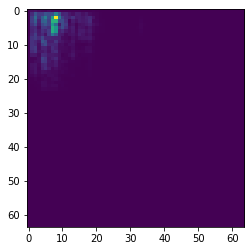

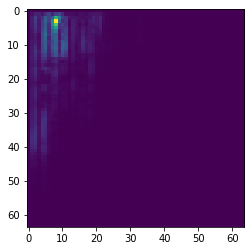

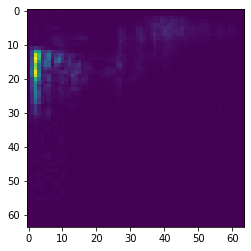

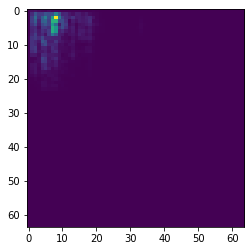

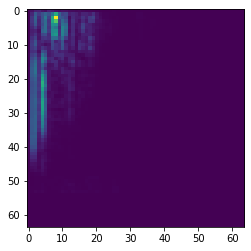

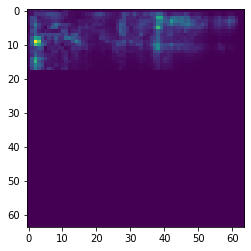

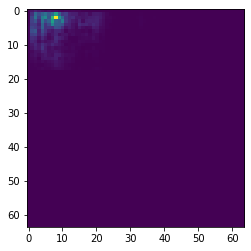

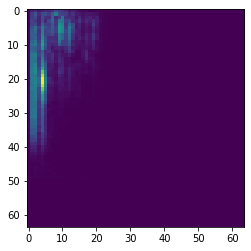

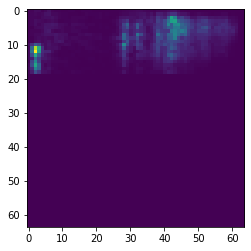

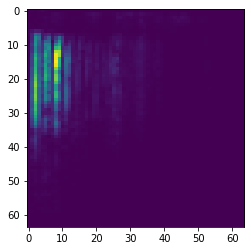

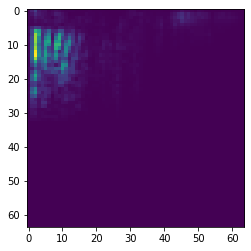

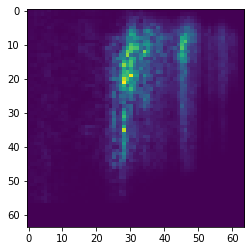

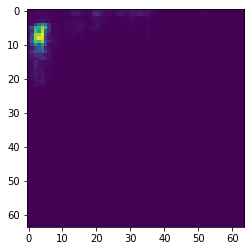

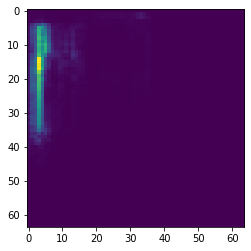

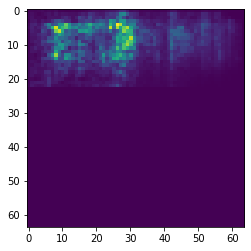

In [155]:
import matplotlib.pyplot as plt

############ FALTA LA CONDICIÓN DE LOS FONEMAS ####################

idx = 1

plt.figure()
plt.imshow(triplet_dataset[idx,:,:64])
plt.figure()
plt.imshow(triplet_dataset[idx,:,64:128])
plt.figure()
plt.imshow(triplet_dataset[idx,:,128:192])

idx = 10

plt.figure()
plt.imshow(triplet_dataset[idx,:,:64])
plt.figure()
plt.imshow(triplet_dataset[idx,:,64:128])
plt.figure()
plt.imshow(triplet_dataset[idx,:,128:192])

idx = 100

plt.figure()
plt.imshow(triplet_dataset[idx,:,:64])
plt.figure()
plt.imshow(triplet_dataset[idx,:,64:128])
plt.figure()
plt.imshow(triplet_dataset[idx,:,128:192])

idx = 1000

plt.figure()
plt.imshow(triplet_dataset[idx,:,:64])
plt.figure()
plt.imshow(triplet_dataset[idx,:,64:128])
plt.figure()
plt.imshow(triplet_dataset[idx,:,128:192])

idx = 10000

plt.figure()
plt.imshow(triplet_dataset[idx,:,:64])
plt.figure()
plt.imshow(triplet_dataset[idx,:,64:128])
plt.figure()
plt.imshow(triplet_dataset[idx,:,128:192])

In [14]:
# Parameters

modes = ['eng_mfcc_env','eng_all_classall','eng_all_classred','eng_all_syllall','eng_all_syllred','eng_all_phonall','eng_all_phonred',
         'vae','classall','classred','syllall','syllred','phonall','phonred'] # Triplet!!
#clfs = ['mlp','logr','knn','rf','xgboost']
clfs = ['knn']

# Calculate utterance-wise weights

num_test_utterances = []
for part in range(28):
    if part<=9:
        test_dataset = np.load('../../data/interim/AVP/Dataset_Test_0' + str(part) + '_1024.npy')
    else:
        test_dataset = np.load('../../data/interim/AVP/Dataset_Test_' + str(part) + '_1024.npy')
    num_test_utterances.append(test_dataset.shape[0])
utterance_wise_weights = num_test_utterances/np.sum(np.array(num_test_utterances))

In [4]:
# Results

for c in range(len(clfs)):

    for b in range(len(modes)):

        mode = modes[b]

        print([mode,clfs[c]])

        accuracies = np.load('../../results/' + mode + '/accuracies.npy')

        frame_sizes = ['1024']

        accuracies = np.mean(accuracies,axis=-1)
        accuracies_allpart = np.mean(accuracies,axis=-2)
        
        for a in range(len(frame_sizes)):
            print(accuracies_allpart[a,c])

['eng_mfcc_env', 'knn']
0.6822082874695076
['eng_all_classall', 'knn']
0.7244200150746297
['eng_all_classred', 'knn']
0.7191614858700905
['eng_all_syllall', 'knn']
0.6527861737775733
['eng_all_syllred', 'knn']
0.6968666907745111
['eng_all_phonall', 'knn']
0.6178408049654627
['eng_all_phonred', 'knn']
0.5789260488287598
['vae', 'knn']
0.7054028133306375
['classall', 'knn']
0.6999940623459006
['classred', 'knn']
0.6329257617077245
['syllall', 'knn']
0.7707182069111667
['syllred', 'knn']
0.7720241129717775
['phonall', 'knn']
0.7474323923292888
['phonred', 'knn']
0.7571520686735821


In [5]:
# Results Also Valid

for c in range(len(clfs)):

    for b in range(len(modes)):

        mode = modes[b]

        print([mode,clfs[c]])

        accuracies = np.load('../../results/' + mode + '/accuracies_also_valid.npy')

        frame_sizes = ['1024']

        accuracies = np.mean(accuracies,axis=-1)
        accuracies_allpart = np.mean(accuracies,axis=-2)
        
        for a in range(len(frame_sizes)):
            print(accuracies_allpart[a,c])

['eng_mfcc_env', 'knn']
0.6909366094279135
['eng_all_classall', 'knn']
0.7312142563417295
['eng_all_classred', 'knn']
0.7257325368151749
['eng_all_syllall', 'knn']
0.6588745201564177
['eng_all_syllred', 'knn']
0.7014448226052783
['eng_all_phonall', 'knn']
0.6229397616965174
['eng_all_phonred', 'knn']
0.5857932465749103
['vae', 'knn']
0.7109027477813896
['classall', 'knn']
0.7048480782052279
['classred', 'knn']
0.6344616406908206
['syllall', 'knn']
0.7754312892352767
['syllred', 'knn']
0.7816773713787514
['phonall', 'knn']
0.754027948072874
['phonred', 'knn']
0.7603867673637985


In [18]:
# Results Utterance-Wise

for c in range(len(clfs)):

    for b in range(len(modes)):

        mode = modes[b]

        print([mode,clfs[c]])

        accuracies = np.load('../../results/' + mode + '/accuracies.npy')

        frame_sizes = ['1024']

        accuracies = np.mean(accuracies,axis=-1)
        accuracies[0,:,0] *= utterance_wise_weights
        accuracies_allpart = np.sum(accuracies,axis=-2)
        
        for a in range(len(frame_sizes)):
            print(accuracies_allpart[a,c])

['eng_mfcc_env', 'knn']
0.6640435835351091
['eng_all_classall', 'knn']
0.6930992736077481
['eng_all_classred', 'knn']
0.6930992736077481
['eng_all_syllall', 'knn']
0.6628329297820824
['eng_all_syllred', 'knn']
0.6761501210653752
['eng_all_phonall', 'knn']
0.6016949152542372
['eng_all_phonred', 'knn']
0.5738498789346247
['vae', 'knn']
0.7039951573849879
['classall', 'knn']
0.6918886198547216
['classred', 'knn']
0.6204600484261502
['syllall', 'knn']
0.7687651331719128
['syllred', 'knn']
0.7512106537530266
['phonall', 'knn']
0.75544794188862
['phonred', 'knn']
0.74455205811138


In [19]:
# Results Utterance-Wise Also Valid

for c in range(len(clfs)):

    for b in range(len(modes)):

        mode = modes[b]

        print([mode,clfs[c]])

        accuracies = np.load('../../results/' + mode + '/accuracies_also_valid.npy')

        frame_sizes = ['1024']

        accuracies = np.mean(accuracies,axis=-1)
        accuracies[0,:,0] *= utterance_wise_weights
        accuracies_allpart = np.sum(accuracies,axis=-2)
        
        for a in range(len(frame_sizes)):
            print(accuracies_allpart[a,c])

['eng_mfcc_env', 'knn']
0.679176755447942
['eng_all_classall', 'knn']
0.7052058111380145
['eng_all_classred', 'knn']
0.7015738498789346
['eng_all_syllall', 'knn']
0.6700968523002422
['eng_all_syllred', 'knn']
0.6846246973365617
['eng_all_phonall', 'knn']
0.608958837772397
['eng_all_phonred', 'knn']
0.5865617433414043
['vae', 'knn']
0.7106537530266344
['classall', 'knn']
0.7003631961259081
['classred', 'knn']
0.6222760290556901
['syllall', 'knn']
0.7717917675544794
['syllred', 'knn']
0.7651331719128329
['phonall', 'knn']
0.7590799031476998
['phonred', 'knn']
0.7487893462469735


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parameters

modes = ['eng_mfcc_env','eng_all_classall','eng_all_classred','eng_all_syllall','eng_all_syllred','eng_all_phonall','eng_all_phonred',
         'vae','classall','classred','syllall','syllred','phonall','phonred'] # Triplet!!
#clfs = ['mlp','logr','knn','rf','xgboost']
clfs = ['knn']

# Calculate utterance-wise weights

num_test_utterances = []
for part in range(28):
    if part<=9:
        test_dataset = np.load('../../data/interim/AVP/Dataset_Test_0' + str(part) + '_1024.npy')
    else:
        test_dataset = np.load('../../data/interim/AVP/Dataset_Test_' + str(part) + '_1024.npy')
    num_test_utterances.append(test_dataset.shape[0])
utterance_wise_weights = num_test_utterances/np.sum(np.array(num_test_utterances))

In [3]:
# Results

for c in range(len(clfs)):

    for b in range(len(modes)):

        mode = modes[b]

        print([mode,clfs[c]])

        accuracies = np.load('../../results/' + mode + '/accuracies.npy')

        frame_sizes = ['1024']

        accuracies = np.mean(accuracies,axis=-1)
        accuracies_allpart = np.mean(accuracies,axis=-2)
        
        for a in range(len(frame_sizes)):
            print(accuracies_allpart[a,c])

['eng_mfcc_env', 'knn']
0.7450167903452326
['eng_all_classall', 'knn']
0.6841175089763681
['eng_all_classred', 'knn']
0.716726295432548
['eng_all_syllall', 'knn']
0.6549831306676802
['eng_all_syllred', 'knn']
0.6976663706406897
['eng_all_phonall', 'knn']
0.6727216270988816
['eng_all_phonred', 'knn']
0.6651871930318041
['vae', 'knn']
0.6977792221895165
['classall', 'knn']
0.6930546150302981
['classred', 'knn']
0.6372316046512074
['syllall', 'knn']
0.771430671818109
['syllred', 'knn']
0.7779648205240258
['phonall', 'knn']
0.7296772123458416
['phonred', 'knn']
0.7470752823198197


In [5]:
# Results Also Valid

for c in range(len(clfs)):

    for b in range(len(modes)):

        mode = modes[b]

        print([mode,clfs[c]])

        accuracies = np.load('../../results/' + mode + '/accuracies_also_valid.npy')

        frame_sizes = ['1024']

        accuracies = np.mean(accuracies,axis=-1)
        accuracies_allpart = np.mean(accuracies,axis=-2)
        
        for a in range(len(frame_sizes)):
            print(accuracies_allpart[a,c])

['eng_mfcc_env', 'knn']
0.6909366094279135
['eng_all_classall', 'knn']
0.7312142563417295
['eng_all_classred', 'knn']
0.7257325368151749
['eng_all_syllall', 'knn']
0.6588745201564177
['eng_all_syllred', 'knn']
0.7014448226052783
['eng_all_phonall', 'knn']
0.6229397616965174
['eng_all_phonred', 'knn']
0.5857932465749103
['vae', 'knn']
0.7109027477813896
['classall', 'knn']
0.7048480782052279
['classred', 'knn']
0.6344616406908206
['syllall', 'knn']
0.7754312892352767
['syllred', 'knn']
0.7816773713787514
['phonall', 'knn']
0.754027948072874
['phonred', 'knn']
0.7603867673637985


In [18]:
# Results Utterance-Wise

for c in range(len(clfs)):

    for b in range(len(modes)):

        mode = modes[b]

        print([mode,clfs[c]])

        accuracies = np.load('../../results/' + mode + '/accuracies.npy')

        frame_sizes = ['1024']

        accuracies = np.mean(accuracies,axis=-1)
        accuracies[0,:,0] *= utterance_wise_weights
        accuracies_allpart = np.sum(accuracies,axis=-2)
        
        for a in range(len(frame_sizes)):
            print(accuracies_allpart[a,c])

['eng_mfcc_env', 'knn']
0.6640435835351091
['eng_all_classall', 'knn']
0.6930992736077481
['eng_all_classred', 'knn']
0.6930992736077481
['eng_all_syllall', 'knn']
0.6628329297820824
['eng_all_syllred', 'knn']
0.6761501210653752
['eng_all_phonall', 'knn']
0.6016949152542372
['eng_all_phonred', 'knn']
0.5738498789346247
['vae', 'knn']
0.7039951573849879
['classall', 'knn']
0.6918886198547216
['classred', 'knn']
0.6204600484261502
['syllall', 'knn']
0.7687651331719128
['syllred', 'knn']
0.7512106537530266
['phonall', 'knn']
0.75544794188862
['phonred', 'knn']
0.74455205811138


In [19]:
# Results Utterance-Wise Also Valid

for c in range(len(clfs)):

    for b in range(len(modes)):

        mode = modes[b]

        print([mode,clfs[c]])

        accuracies = np.load('../../results/' + mode + '/accuracies_also_valid.npy')

        frame_sizes = ['1024']

        accuracies = np.mean(accuracies,axis=-1)
        accuracies[0,:,0] *= utterance_wise_weights
        accuracies_allpart = np.sum(accuracies,axis=-2)
        
        for a in range(len(frame_sizes)):
            print(accuracies_allpart[a,c])

['eng_mfcc_env', 'knn']
0.679176755447942
['eng_all_classall', 'knn']
0.7052058111380145
['eng_all_classred', 'knn']
0.7015738498789346
['eng_all_syllall', 'knn']
0.6700968523002422
['eng_all_syllred', 'knn']
0.6846246973365617
['eng_all_phonall', 'knn']
0.608958837772397
['eng_all_phonred', 'knn']
0.5865617433414043
['vae', 'knn']
0.7106537530266344
['classall', 'knn']
0.7003631961259081
['classred', 'knn']
0.6222760290556901
['syllall', 'knn']
0.7717917675544794
['syllred', 'knn']
0.7651331719128329
['phonall', 'knn']
0.7590799031476998
['phonred', 'knn']
0.7487893462469735
